In [1]:
import os
import torch
import torchvision

In [2]:
mdoel_index = 0

model_list = ['fcn_resnet50', #0
              'fcn_resnet101',#1
              'deeplabv3_resnet50', #2
              'deeplabv3_resnet101', #3 
              'deeplabv3_mobilenet_v3_large', #4
              'lraspp_mobilenet_v3_large' #5
             ]

def fcn_resnet50():
    model = torchvision.models.segmentation.fcn_resnet50(pretrained=True).cuda()
    return model

def fcn_resnet101():
    model = torchvision.models.segmentation.fcn_resnet101(pretrained=True).cuda()
    return model

def deeplabv3_resnet50():
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True).cuda()
    return model

def deeplabv3_resnet101():
    model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).cuda()
    return model

def deeplabv3_mobilenet_v3_large():
    model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True).cuda()
    return model

def lraspp_mobilenet_v3_large():
    model = torchvision.models.segmentation.lraspp_mobilenet_v3_large(pretrained=True).cuda()
    return model

def default():
    print('Please choose the right model index')
    print(model_list)
    return None
choose_model = {'fcn_resnet50': fcn_resnet50,
                'fcn_resnet101': fcn_resnet101,
                'deeplabv3_resnet50': deeplabv3_resnet50,
                'deeplabv3_resnet101': deeplabv3_resnet101,
                'deeplabv3_mobilenet_v3_large': deeplabv3_mobilenet_v3_large,
                'lraspp_mobilenet_v3_large': lraspp_mobilenet_v3_large
               }

model_name = model_list[mdoel_index]
model = choose_model.get(model_name, default)()
# print(model)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
from pathlib import Path

input_image1 = read_image(str(Path('assets') / 'dog1.jpg'))
# input_image2 = read_image(str(Path('assets') / 'dog2.jpg'))
model = model.eval()

batch_images = torch.stack([input_image1, input_image1])
batch = convert_image_dtype(batch_images, dtype=torch.float)

normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

output = model(normalized_batch.cuda())['out']
print(output.shape, output.min().item(), output.max().item())

sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])     

torch.Size([2, 21, 640, 512]) -6.3515849113464355 14.941158294677734


dog1_masks shape = torch.Size([21, 640, 512]), dtype = torch.float32
dog1_all_classes_masks = torch.Size([21, 640, 512]), dtype = torch.bool
-------plot the multi boolen masks on orignal images-------


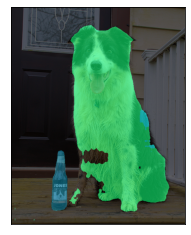

In [4]:
from torchvision.utils import draw_segmentation_masks
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim).cuda() == torch.arange(num_classes)[:, None, None].cuda()

print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")
print('-------plot the multi boolen masks on orignal images-------')
dog_with_all_masks = draw_segmentation_masks(input_image1, masks=dog1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)

In [5]:
batch_size = 1
color_channel = 3
height = 256
width = 256

input_names = ['input0'] + ['learned_%d' %i for i in range(16)]
output_names = ['dense_out']
dummy_input = torch.randn(batch_size, color_channel, width, height, device='cuda')
onnx_model_name = model_name + '.onnx'
dynamic_axes = {'input0': {0:'batch', 2:'height', 3:'width'}}

torch.onnx.export(model,
                 dummy_input,
                 onnx_model_name,
                 input_names=input_names,
                 output_names=output_names,
                 opset_version=12,
                 dynamic_axes=dynamic_axes)

In [6]:
import tensorrt as trt
from calibrator import EntropyCalibrator
import common
calibration_cache = "mnist_calibration.cache"


def build_int8_engine(onnx_file_path, calibrator, batch_size, calibration_cache):
    # with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, builder.create_builder_config() as config, trt.CaffeParser() as parser:
    EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network(common.EXPLICIT_BATCH) as network, \
            builder.create_builder_config() as config, trt.OnnxParser(network,TRT_LOGGER) as parser:
        # We set the builder batch size to be the same as the calibrator's, as we use the same batches
        # during inference. Note that this is not required in general, and inference batch size is
        # independent of calibration batch size.
        builder.max_batch_size = batch_size

        config.max_workspace_size = common.GiB(1)
        config.set_flag(trt.BuilderFlag.INT8)
        config.set_flag(trt.BuilderFlag.STRICT_TYPES)
        config.int8_calibrator = calib

        # Parse Onnx model
        with open(onnx_file_path, 'rb') as model:
            print('Beginning ONNX file parsing')
            if not parser.parse(model.read()):
                print('ERROR: Failed to parse the ONNX file.')
                for error in range(parser.num_errors):
                    print(parser.get_error(error))
                return None
        
        # For the fixed batch, please use the following code
        #network.get_input(0).shape = [batch_size, 3, 32, 32]
        
        # For dynamic batch, please use the following code
        profile = builder.create_optimization_profile();
        profile.set_shape("input0", (1, 3, 256, 256), (32, 3, 512, 512), (64, 3, 640, 640))
        config.add_optimization_profile(profile)
        config.set_calibration_profile(profile)

#         #Decide which layers fallback to FP32. #If all layers fallback to FP32, you can use 'index>-1'
#         for index, layer in enumerate(network):
#             print('layer index', index, ':', layer.type, layer.name)
#             if index < 10:
#                 if layer.type == trt.LayerType.ACTIVATION or \
#                         layer.type == trt.LayerType.CONVOLUTION or \
#                         layer.type == trt.LayerType.FULLY_CONNECTED or \
#                         layer.type == trt.LayerType.SCALE:
#                     print('layer index', index, ':', layer.type, 'will be', 'fallback to fp32!')
#                     layer.precision = trt.float32
#                     layer.set_output_type(0, trt.float32)
                    
#         ### setting dynamic range for the output of activation layer
#         ### here, we set the output of layer[64] ReLu to [-6, 6]
#         layer=network[45]
#         tensor = layer.get_output(0)
#         tensor.dynamic_range = (-6.0, 6.0)  

        # Start to build engine and do int8 calibration.
        print('--- Starting to build engine! ---')
        engine = builder.build_engine(network, config)
        print('--- Building engine is finished! ---')
        
        ### Using the calibration cache to pick out correspondding network layer
        cache_dict = convert_calib_cache(calibration_cache)
        if cache_dict is not None:
            for index, layer in enumerate(network):
                for i in range(layer.num_outputs):
                    output_tensor = layer.get_output(i)
                    if output_tensor.name in cache_dict:
                        hex_str = cache_dict[output_tensor.name]                    
                        scale = struct.unpack('!f', bytes.fromhex(hex_str))[0]
                        print('Layer index is:', index, '; ', \
                              'Activations dynamic range is: (-/+)', scale * 127.0, '; ',\
                              'Layer type is:', layer.type)#, ';', \
                              #'output tensor name is:', output_tensor.name)
        return engine

In [ ]:
ONNX_PATH = "fcn_resnet50.onnx"
calib_data_path = 'calibration/'

# Now we create a calibrator and give it the location of our calibration data.
# We also allow it to cache calibration data for faster engine building.
calibration_cache = "mnist_calibration.cache"
calib = EntropyCalibrator(calib_data_path, total_images=300, batch_size=1, cache_file=calibration_cache)
    
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)       
batch_size = 1 # This is inference batch size that can be different from calibration batch size.
with build_int8_engine(ONNX_PATH, calib, batch_size, calibration_cache) as engine, engine.create_execution_context() as context:                    
    context.active_optimization_profile = 0  # For dynamic shapes
    context.set_binding_shape(0, (batch_size, 3, 32, 32))  # For dynamic shapes
        
#     # Batch size for inference can be different than batch size used for calibration.
#     test_set, test_labels = load_cifar_data(cifar10_data_path)
#     check_accuracy(context, batch_size, test_set=test_set, test_labels=test_labels)

[01/11/2022-07:43:36] [TRT] [I] [MemUsageChange] Init CUDA: CPU +448, GPU +0, now: CPU 3913, GPU 6058 (MiB)
Beginning ONNX file parsing
[01/11/2022-07:43:36] [TRT] [I] [MemUsageSnapshot] Begin constructing builder kernel library: CPU 3913 MiB, GPU 6058 MiB
[01/11/2022-07:43:36] [TRT] [I] [MemUsageSnapshot] End constructing builder kernel library: CPU 4067 MiB, GPU 6102 MiB
[01/11/2022-07:43:36] [TRT] [V] Registered plugin creator - ::BatchTilePlugin_TRT version 1
[01/11/2022-07:43:36] [TRT] [V] Registered plugin creator - ::BatchedNMS_TRT version 1
[01/11/2022-07:43:36] [TRT] [V] Registered plugin creator - ::BatchedNMSDynamic_TRT version 1
[01/11/2022-07:43:36] [TRT] [V] Registered plugin creator - ::CoordConvAC version 1
[01/11/2022-07:43:36] [TRT] [V] Registered plugin creator - ::CropAndResize version 1
[01/11/2022-07:43:36] [TRT] [V] Registered plugin creator - ::CropAndResizeDynamic version 1
[01/11/2022-07:43:36] [TRT] [V] Registered plugin creator - ::DetectionLayer_TRT version

/tmp/ipykernel_2082/913249186.py:60: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


[01/11/2022-07:43:37] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +37, GPU +58, now: CPU 4273, GPU 6232 (MiB)
[01/11/2022-07:43:37] [TRT] [I] Timing cache disabled. Turning it on will improve builder speed.
[01/11/2022-07:43:37] [TRT] [V] Constructing calibration profile.
[01/11/2022-07:43:37] [TRT] [V] Reserving memory for activation tensors. Host: 0 bytes Device: 1509949440 bytes
[01/11/2022-07:43:37] [TRT] [V] =============== Computing reformatting costs
[01/11/2022-07:43:37] [TRT] [V] =============== Computing reformatting costs
[01/11/2022-07:43:37] [TRT] [V] =============== Computing reformatting costs
[01/11/2022-07:43:37] [TRT] [V] =============== Computing reformatting costs
[01/11/2022-07:43:37] [TRT] [V] =============== Computing reformatting costs
[01/11/2022-07:43:37] [TRT] [V] =============== Computing reformatting costs
[01/11/2022-07:43:37] [TRT] [V] =============== Computing reformatting costs
[01/11/2022-07:43:37] [TRT] [V] =============== Computing reformatting costs


[01/11/2022-07:43:37] [TRT] [V] Tactic: 112 Time: 4.9193
[01/11/2022-07:43:37] [TRT] [V] Tactic: 112 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:37] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 112
[01/11/2022-07:43:37] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:37] [TRT] [V] *************** Autotuning format combination: Float(4194304,65536,256,1) -> Float(4194304,65536,256,1) ***************
[01/11/2022-07:43:37] [TRT] [V] --------------- Timing Runner: PWN(Relu_7) (PointWiseV2)
[01/11/2022-07:43:37] [TRT] [V] Tactic: 0 Time: 1.5657
[01/11/2022-07:43:37] [TRT] [V] Tactic: 0 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:37] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 0
[01/11/2022-07:43:37] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:37] [TRT] [V] *************** Autotuning format combination: Float(4194304,65536,256,1) -> Float(1048576

[01/11/2022-07:43:38] [TRT] [V] Tactic: 112 Time: 3.28499
[01/11/2022-07:43:38] [TRT] [V] Tactic: 112 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:38] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 112
[01/11/2022-07:43:38] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:38] [TRT] [V] *************** Autotuning format combination: Float(4194304,16384,128,1), Float(4194304,16384,128,1) -> Float(4194304,16384,128,1) ***************
[01/11/2022-07:43:38] [TRT] [V] --------------- Timing Runner: Add_29 (ElementWise)
[01/11/2022-07:43:38] [TRT] [V] Tactic: 1 Time: 2.34394
[01/11/2022-07:43:38] [TRT] [V] Tactic: 1 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:38] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: ElementWise Tactic: 1
[01/11/2022-07:43:38] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:38] [TRT] [V] *************** Autotuning format combination: Float(4194304,1638

[01/11/2022-07:43:38] [TRT] [V] Tactic: 0 Time: 0.784512
[01/11/2022-07:43:38] [TRT] [V] Tactic: 0 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:38] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 0
[01/11/2022-07:43:38] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:38] [TRT] [V] *************** Autotuning format combination: Float(2097152,4096,64,1) -> Float(524288,4096,64,1) ***************
[01/11/2022-07:43:38] [TRT] [V] --------------- Timing Runner: Conv_53 (FusedConvActConvolution)
[01/11/2022-07:43:38] [TRT] [V] FusedConvActConvolution has no valid tactics for this config, skipping
[01/11/2022-07:43:38] [TRT] [V] --------------- Timing Runner: Conv_53 (CudaDepthwiseConvolution)
[01/11/2022-07:43:38] [TRT] [V] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[01/11/2022-07:43:38] [TRT] [V] --------------- Timing Runner: Conv_53 (CudnnConvolution)
[01/11/2022-07:43:38] [TRT] [V] Tactic: 112 Ti

[01/11/2022-07:43:38] [TRT] [V] Tactic: 112 Time: 7.49363
[01/11/2022-07:43:38] [TRT] [V] Tactic: 112 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:38] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 112
[01/11/2022-07:43:38] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:38] [TRT] [V] *************** Autotuning format combination: Float(1048576,4096,64,1) -> Float(1048576,4096,64,1) ***************
[01/11/2022-07:43:38] [TRT] [V] --------------- Timing Runner: PWN(Relu_71) (PointWiseV2)
[01/11/2022-07:43:38] [TRT] [V] Tactic: 0 Time: 0.395264
[01/11/2022-07:43:38] [TRT] [V] Tactic: 0 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:38] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 0
[01/11/2022-07:43:38] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:38] [TRT] [V] *************** Autotuning format combination: Float(1048576,4096,64,1) -> Float(4194304,4

[01/11/2022-07:43:38] [TRT] [V] Tactic: 112 Time: 5.63507
[01/11/2022-07:43:38] [TRT] [V] Tactic: 112 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:38] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 112
[01/11/2022-07:43:38] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:38] [TRT] [V] *************** Autotuning format combination: Float(4194304,4096,64,1), Float(4194304,4096,64,1) -> Float(4194304,4096,64,1) ***************
[01/11/2022-07:43:38] [TRT] [V] --------------- Timing Runner: Add_87 (ElementWise)
[01/11/2022-07:43:38] [TRT] [V] Tactic: 1 Time: 2.33779
[01/11/2022-07:43:38] [TRT] [V] Tactic: 1 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:38] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: ElementWise Tactic: 1
[01/11/2022-07:43:38] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:38] [TRT] [V] *************** Autotuning format combination: Float(4194304,4096,64,1)

[01/11/2022-07:43:38] [TRT] [V] Tactic: 0 Time: 1.56672
[01/11/2022-07:43:38] [TRT] [V] Tactic: 0 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:38] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 0
[01/11/2022-07:43:38] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:38] [TRT] [V] *************** Autotuning format combination: Float(4194304,4096,64,1) -> Float(2097152,4096,64,1) ***************
[01/11/2022-07:43:38] [TRT] [V] --------------- Timing Runner: Conv_103 (FusedConvActConvolution)
[01/11/2022-07:43:38] [TRT] [V] FusedConvActConvolution has no valid tactics for this config, skipping
[01/11/2022-07:43:38] [TRT] [V] --------------- Timing Runner: Conv_103 (CudaDepthwiseConvolution)
[01/11/2022-07:43:38] [TRT] [V] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[01/11/2022-07:43:38] [TRT] [V] --------------- Timing Runner: Conv_103 (CudnnConvolution)
[01/11/2022-07:43:39] [TRT] [V] Tactic: 112

[01/11/2022-07:43:39] [TRT] [V] Tactic: 112 Time: 39.6943
[01/11/2022-07:43:39] [TRT] [V] Tactic: 112 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:39] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 112
[01/11/2022-07:43:39] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:39] [TRT] [V] *************** Autotuning format combination: Float(2097152,4096,64,1) -> Float(2097152,4096,64,1) ***************
[01/11/2022-07:43:39] [TRT] [V] --------------- Timing Runner: PWN(Relu_114) (PointWiseV2)
[01/11/2022-07:43:39] [TRT] [V] Tactic: 0 Time: 0.784384
[01/11/2022-07:43:39] [TRT] [V] Tactic: 0 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:39] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 0
[01/11/2022-07:43:39] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:39] [TRT] [V] *************** Autotuning format combination: Float(2097152,4096,64,1) -> Float(8388608,

[01/11/2022-07:43:40] [TRT] [V] Tactic: 112 Time: 167.572
[01/11/2022-07:43:40] [TRT] [V] Tactic: 112 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:40] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 112
[01/11/2022-07:43:40] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:40] [TRT] [V] *************** Autotuning format combination: Float(2097152,4096,64,1) -> Float(2097152,4096,64,1) ***************
[01/11/2022-07:43:40] [TRT] [V] --------------- Timing Runner: PWN(Relu_126) (PointWiseV2)
[01/11/2022-07:43:40] [TRT] [V] Tactic: 0 Time: 0.786528
[01/11/2022-07:43:40] [TRT] [V] Tactic: 0 A valid tactic is found. Rest of the tactics are skipped.
[01/11/2022-07:43:40] [TRT] [V] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 0
[01/11/2022-07:43:40] [TRT] [V] =============== Computing costs for 
[01/11/2022-07:43:40] [TRT] [V] *************** Autotuning format combination: Float(2097152,4096,64,1) -> Float(86016,40

In [ ]:
commond = 'trtexec' + ' --onnx=' + onnx_model_name + ' --shapes=input0:1x3x512x512' + ' --int8'
cli_output = os.popen(commond).read()
print(cli_output)
# !trtexec --onnx=onnx_model_name --shapes=input0:1x3x512x512